# Setup

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_machine_learning.utils import algorithm_globals
from scipy.optimize import minimize
from numpy.typing import NDArray
from qiskit_aer import AerSimulator
from tqdm import tqdm

In [64]:
seed = 43

algorithm_globals.random_seed = seed
np.random.seed(seed)

In [65]:
num_inputs = 1 # num of features (p)
num_samples_train = 512 # num of instances (n)
batch_size = 32
num_samples_test = 32
test_batch_size = 32
num_params = 4
nb_iter = 600

In [66]:
backend = AerSimulator()

In [67]:
# Points between -2 and 2 on a single axis
X = 4 * algorithm_globals.random.random(num_samples_train) - 2  
X_test = 4 * algorithm_globals.random.random(num_samples_test) - 2

# Blue if between -1 and 1, red otherwise
Y = np.where((X >= -1) & (X <= 1), 1, -1)  # Y contains 1 and -1
Y_test = np.where((X_test >= -1) & (X_test <= 1), 1, -1)

# Ensure the arrays are of type float64
X = X.astype(np.float64)
Y = Y.astype(np.float64)
X_test = X_test.astype(np.float64)
Y_test = Y_test.astype(np.float64)

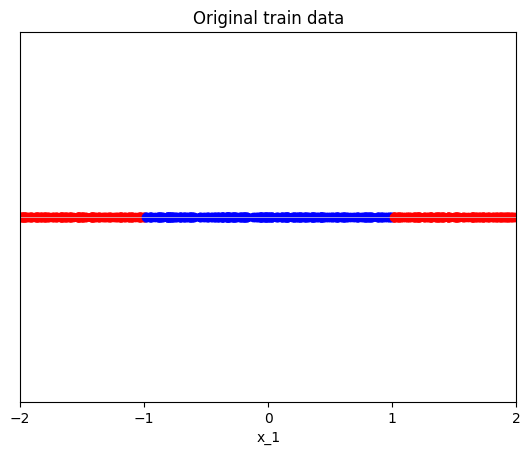

In [68]:
# On plot la distribution
for x_i, y_i in zip(X, Y):
    if y_i == 1:
        plt.plot(x_i, 0, "bo") 
    else:
        plt.plot(x_i, 0, "ro")

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Original train data")
plt.xlabel("x_1")
plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([])
plt.xlim(-2, 2)
plt.show()

# Model

In [69]:
class QuantumModel() :
    def __init__(self, paramValues: NDArray[np.float64], X: NDArray[np.float64], Y: NDArray[np.float64], batch_size: int,
                  test_batch_size: int, backend, circuit = None, transpiledCircuit = None, shots = 1024,
                  parameterList = [Parameter("x1"), Parameter("x2"), Parameter("theta1"), Parameter("theta2"), Parameter("theta3"), Parameter("theta4")]) :
        
        self.paramValues: NDArray[np.float64] = paramValues
        self.X: NDArray[np.float64] = X
        self.Y: NDArray[np.float64] = Y
        self.batch_size: int = batch_size
        self.test_batch_size: int = test_batch_size
        self.shots: int = shots
        self.backend = backend
        self.parameterList = parameterList

        self.circuit = circuit
        self.transpiledCircuit = transpiledCircuit

    def updateParams(self, new_param_values: NDArray[np.float64]) :
        self.paramValues: NDArray[np.float64] = new_param_values

    def createCircuit(self) :

        qc = QuantumCircuit(3,1)

        qc.ry(self.parameterList[0], 1)
        qc.rx(self.parameterList[2], 1)
        qc.rx(self.parameterList[0], 1)
        qc.ry(self.parameterList[3], 1)
        qc.rx(self.parameterList[0], 1)
        qc.ry(self.parameterList[4], 1)
        qc.rx(self.parameterList[0], 1)
        qc.ry(self.parameterList[5], 1)
        qc.rx(self.parameterList[0], 1)

        qc.ry(self.parameterList[1], 2)
        qc.rx(self.parameterList[2], 2)
        qc.rx(self.parameterList[1], 2)
        qc.ry(self.parameterList[3], 2)
        qc.rx(self.parameterList[1], 2)
        qc.ry(self.parameterList[4], 2)
        qc.rx(self.parameterList[1], 2)
        qc.ry(self.parameterList[5], 2)
        qc.rx(self.parameterList[1], 2)

        qc.h(0)
        qc.cswap(0, 1, 2)
        qc.h(0)

        qc.measure(0, 0)

        self.circuit = qc

    def transpileCircuit(self) :
        self.transpiledCircuit = transpile(self.circuit, backend=self.backend)

    def fidelity(self, x1: np.float64, x2: np.float64) -> np.float64:

        parametersDict = {
            self.parameterList[0]: x1,
            self.parameterList[1]: x2,
            self.parameterList[2]: self.paramValues[0],
            self.parameterList[3]: self.paramValues[1],
            self.parameterList[4]: self.paramValues[2],
            self.parameterList[5]: self.paramValues[3]
        }

        assert self.transpiledCircuit is not None, "The transpiled circuit must be defined"
        boundCircuit = self.transpiledCircuit.assign_parameters(parametersDict)

        job = backend.run(boundCircuit, shots=self.shots)
        result = job.result()

        counts = result.get_counts() # de la forme : {'0': 979, '1': 45}

        zeros, ones = 0, 0
        if '0' in counts.keys() :
            zeros = counts['0']
        if '1' in counts.keys() :
            ones = counts['1']

        return np.float64((zeros - ones) / self.shots)

    def trace(self, class1: NDArray[np.float64], class2: NDArray[np.float64]) -> np.float64 :
        """
        Compute the trace of the density matrix of class1 multiplied by the density matrix of class2

        class1, class2 are arrays of data corresponding to each class
        """
        result = np.float64(0)


        for x1 in class1 :
            for x2 in class2 :
                result += self.fidelity(x1, x2)
        
        return result

    def Dhs(self) -> np.float64 :
        indices = np.random.choice(len(self.X), size=self.batch_size, replace=False)
        
        # Split the sampled data into two classes based on Y labels
        Xsample = self.X[indices]
        Ysample = self.Y[indices]
        
        Xpositive = Xsample[Ysample == 1]
        Xnegative = Xsample[Ysample == -1] 

        return self.trace(Xpositive,Xpositive) + self.trace(Xnegative, Xnegative) - 2*self.trace(Xpositive, Xnegative)

    def loss(self) -> np.float64 :
        return 1-0.5*self.Dhs()
    
    def xrhox(self, x: np.float64, class1: NDArray[np.float64]) -> np.float64 :
        result = np.float64(0)

        for x1 in class1 :
            result += self.fidelity(x, x1)
        
        return result
    
    def fidelityMeasurement(self, x: np.float64) -> np.float64 :
        indices = np.random.choice(len(self.X), size=self.test_batch_size, replace=False)

        Xsample = self.X[indices]
        Ysample = self.Y[indices]
        
        Xpositive = Xsample[Ysample == 1]
        Xnegative = Xsample[Ysample == -1] 

        return self.xrhox(x, Xpositive) - self.xrhox(x, Xnegative)
    
    def predict(self, x) :
        out = self.fidelityMeasurement(x)

        if out > 0 :
            return 1
        else :
            return -1
    
    def predictArray(self, X: NDArray[np.float64]) -> NDArray[np.float64] :
        return np.array([self.predict(x) for x in X])

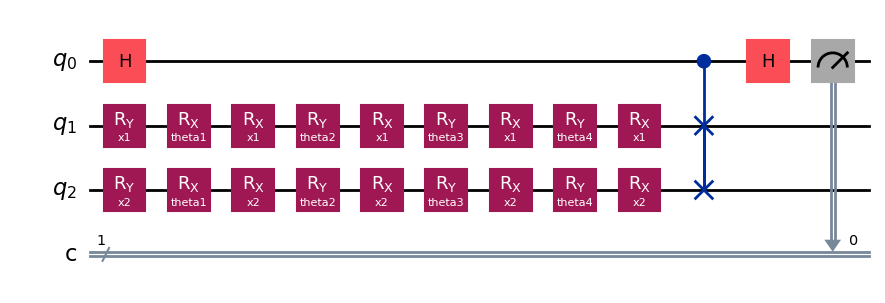

In [70]:
initParams = np.zeros(num_params, dtype=np.float64)

qm = QuantumModel(initParams, X, Y, batch_size, test_batch_size, backend)

qm.createCircuit()
qm.transpileCircuit()

qm.circuit.draw("mpl")

# Optimisation

In [71]:
def objectiveFunction(params_: NDArray[np.float64]) -> np.float64 :

    qm.updateParams(params_)
    loss = qm.loss()


    return loss


In [56]:

def train() :

    with tqdm(total=nb_iter) as pbar:
        def callback(xk):
            pbar.update(1)

        result = minimize(objectiveFunction, initParams, method="COBYLA", options={'maxiter': nb_iter}, callback=callback)

    return result

result = train()
print(result)


  8%|▊         | 48/600 [06:05<1:08:57,  7.50s/it]

# Inference

In [58]:
def computeAccuracy() :
    params = result.x
    qm.updateParams(params)

    testFidelities = np.array([qm.fidelityMeasurement(x) for x in X_test])

    corrects = np.sum(np.where(testFidelities > 0, 1, -1) == Y_test)
    total = len(Y_test)
    accuracy = corrects / total

    return corrects, total, accuracy

def printAccuracy() :
    corrects, total, accuracy = computeAccuracy()
    print(f"Corrects : {corrects} / {total}")
    print(f"Accuracy : {accuracy}")

printAccuracy() #random is 0.5 accuracy

Corrects : 54 / 64
Accuracy : 0.84375


# Plots

In [59]:

def plotPredictionsOnTest(params: NDArray[np.float64]) :
    qm.updateParams(params)

    Y_predict = qm.predictArray(X_test)

    for i in range(len(X_test)) :
        if Y_predict[i] > 0 :
            plt.plot(X_test[i], 0, "bo")
        else :
            plt.plot(X_test[i], 0, "ro")

        # On entoure les instances mal classifiées en vert
        if Y_test[i] != Y_predict[i] :
            plt.scatter(X_test[i], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

    plt.axhline(0, color="lightgray", linewidth=0.5)

    plt.axvline(x=1, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=-1, color='gray', linestyle='--', linewidth=1)

    plt.title("Predicted test data")
    plt.xlabel("x_1")
    plt.xticks([-2, -1, 0, 1, 2])
    plt.yticks([])
    plt.xlim(-2, 2)
    plt.show()

### With random parameters

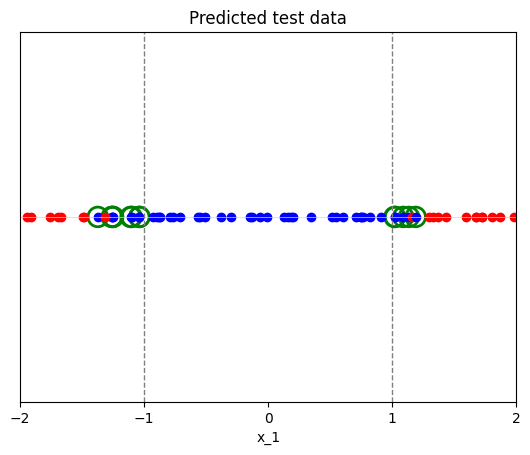

In [ ]:
randomParams = 4 * np.pi * algorithm_globals.random.random(num_params)

plotPredictionsOnTest(randomParams)

### With optimized parameters

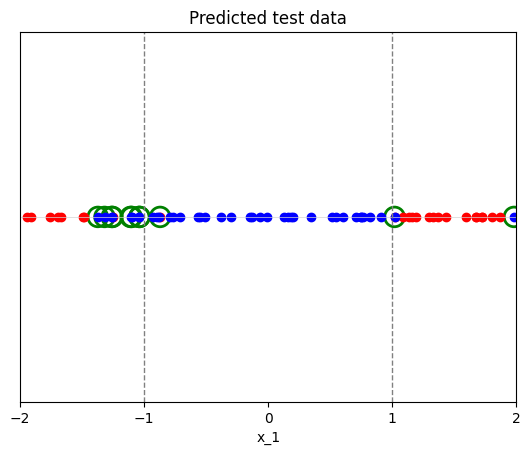

In [61]:
optimalParams = result.x

plotPredictionsOnTest(optimalParams)

# Inspiration

In [62]:
return 0

SyntaxError: 'return' outside function (1987156748.py, line 1)

In [54]:
# Use Aer

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Définir le backend (modifiez ici pour passer sur une machine réelle)
backend = AerSimulator()

# Définir des paramètres
param1 = Parameter('θ1')
param2 = Parameter('θ2')

# Créer un circuit quantique avec des paramètres
qc = QuantumCircuit(1)  # Un seul qubit
qc.rx(param1, 0)        # Rotation autour de X
qc.ry(param2, 0)        # Rotation autour de Y
qc.rx(param1, 0)        # Rotation autour de X
qc.measure_all()        # Mesurer tous les qubits

transpiled_circuit = transpile(qc, backend)

bound_circuit = transpiled_circuit.assign_parameters({param1: 0.5, param2: 1.2}) # Dans assign_parameters : dico dont les keys sont des Parameter objects et les values des float

# Exécuter le circuit
job = backend.run(bound_circuit, shots=1024)
result = job.result()

# Afficher les résultats
counts = result.get_counts()
print("Résultats :", counts)

Résultats : {'0': 535, '1': 489}


In [105]:
#plotting

# On génère les valeurs prédites sur le test set
y_predict_test = estimator_classifier.predict(X_test)

# On plot le résultat
# Red circles indicate misclassified points
for x, y_target, y_p in zip(X_test, y_test, y_predict_test):
    if y_p == 1:
        plt.plot(x[0], 0, "bo") 
    else:
        plt.plot(x[0], 0, "ro")
    
    # On entoure les instances mal classifiées en vert
    if y_target != y_p:
        plt.scatter(x[0], 0, s=200, facecolors="none", edgecolors="g", linewidths=2)

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Prediction Results (Green = Misclassified)")
plt.xlabel("x_1")
plt.show()
score_test = estimator_classifier.score(X_test, y_test)
print(f"Score sur les données de test: {score_test}")

NameError: name 'estimator_classifier' is not defined

In [ ]:
# assign and run a circuit

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the circuit (example: 4 parameters)
params = [Parameter("x1"), Parameter("theta1"), Parameter("theta2"), Parameter("theta3")]

# Create a quantum circuit with 1 qubit and 1 classical bit
qcc = QuantumCircuit(1, 1)

# Apply gates with parameters
qcc.rx(params[0], 0)  # First RX gate
qcc.ry(params[1], 0)  # First RY gate
qcc.rx(params[2], 0)  # Second RX gate
qcc.ry(params[3], 0)  # Second RY gate

# Add a measurement operation
qcc.measure(0, 0)

# Define the parameter values to bind to the circuit
param_values = {params[0]: np.pi / 2, params[1]: np.pi / 4, params[2]: np.pi / 3, params[3]: np.pi / 6}

# Bind the parameters to the circuit
qcc_with_params = qcc.assign_parameters(param_values)

# Set up the estimator and run the circuit
estimator = Estimator()

# Define the Pauli operator for measurement (Z operator in this case)
pauli_z = Pauli('Z')

# Run the estimator on the circuit with the Pauli operator
job = estimator.run([qcc_with_params], [pauli_z])

# Get the result from the execution
result = job.result().values[0]

# Print the average measurement result
print("Average Measurement Result:", result)


Average Measurement Result: -0.76953125


In [ ]:
# cobyla tuto

def objective_function(params_):
    return params_[0]**2 + params_[1]**2 + params_[2]**2 + params_[3]**2

def train() :
    initial_params = np.array([1.0, -1.0, 10.0, 999.0])

    result = minimize(objective_function, initial_params, method="COBYLA", options={'maxiter': 10000})

    return result

result = train()
print(result)


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 2.228145834458338e-09
       x: [-2.429e-06  2.538e-05  1.476e-05 -3.688e-05]
    nfev: 1092
   maxcv: 0.0


In [ ]:
#multiqubit swap test maybe

from qiskit import QuantumCircuit

def create_swap_test(num_qubits: int):
    """
    Creates a swap test circuit.

    Args:
        num_qubits: The total number of qubits in the two registers to be compared.

    Returns:
        A QuantumCircuit implementing the swap test.
    """
    # The swap test needs 1 ancillary qubit and 2 registers of qubits
    swap_test_circuit = QuantumCircuit(num_qubits + 1, 1)

    # Apply a Hadamard gate to the ancillary qubit
    swap_test_circuit.h(0)

    # Apply controlled-SWAP gates between the two qubit registers
    for i in range(1, (num_qubits // 2) + 1):
        swap_test_circuit.cswap(0, i, i + (num_qubits // 2))

    # Apply another Hadamard gate to the ancillary qubit
    swap_test_circuit.h(0)

    # Measure the ancillary qubit
    swap_test_circuit.measure(0, 0)

    return swap_test_circuit


In [ ]:
#cat

x1 = 2

fullparams = np.concatenate(([x1], initParams))

print(fullparams)